# 入力が２値の場合のHGF


入力では、２値の場合のHGFについて、シミュレーションとパラメータ推定をします。以下の内容は、[HierarchicalGaussianFiltering.jlのtutorial](https://github.com/ilabcode/HierarchicalGaussianFiltering.jl/blob/main/docs/tutorials/classic_binary.jl)の内容を参考に作成しています。また、入力と反応は、[toreerdmann/HGF-workshop](https://github.com/toreerdmann/HGF-workshop)の例を使っています。

## 使用するJuliaパッケージ

In [1]:
using ActionModels
using HierarchicalGaussianFiltering
using CSV
using DataFrames
using Plots
using StatsPlots
using Distributions
using LogExpFunctions
using Turing
using Suppressor
ENV["COLUMNS"] = 1000;

## 使用するデータ

[Iglesias et al.(2021)](https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/458335/1-s2.0-S1053811920310752-main.pdf?sequence=3&isAllowed=y)で使われている、音の提示の後にノイズの入った家と顔の画像を提示して判断させる課題のデータを使います。この課題では、音と画像との関係は実験中に変動します（高い音が出た後に顔が提示される確率など）。課題については、リンク先の図を見ると分かりやすいです。なお、この課題は、Iglesias et al.(2013)で作成されたものであり、HGFの適用の多い課題です。


- Iglesias, S., Kasper, L., Harrison, S. J., Manka, R., Mathys, C., & Stephan, K. E. (2021). Cholinergic and dopaminergic effects on prediction error and uncertainty responses during sensory associative learning. NeuroImage, 226, 117590.
- Iglesias, S., Mathys, C., Brodersen, K. H., Kasper, L., Piccirelli, M., den Ouden, H. E. M., & Stephan, K. E. (2013). Hierarchical prediction errors in midbrain and basal forebrain during sensory learning. Neuron, 80(2), 519–530.

[toreerdmann/HGF-workshop](https://github.com/toreerdmann/HGF-workshop)で使われている入力(u)を使います。ここでの入力は、音（高・低）と画像（顔・家）を組み合わせたものになります(画像ではない)。

|      |   高い音   |　低い音  |
| ---- | ---- | ---- |
|  顔  |  1   |   0　 |
|  家  |  0   |   1  |  

In [2]:
inputs = Bool[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0];

プロットしてデータを可視化します。

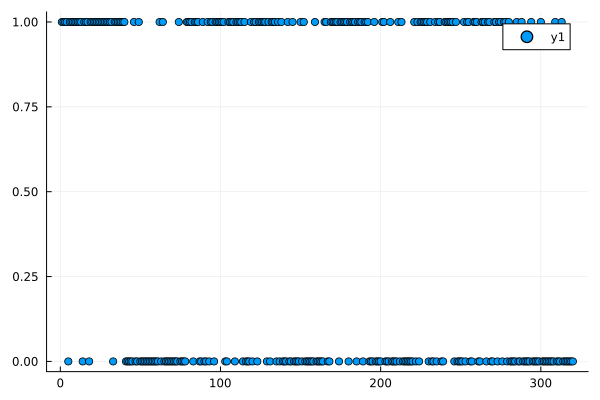

In [3]:
plot(inputs, seriestype=:scatter)

ちょっとわかりにくいので、最初の100施行を抜き出してプロットします。４０施行ぐらいまでは１が多く（高音-顔もしくは低音-家が多い）、４０施行ぐらいからは０が多く（低音-顔もしくは高音-家が多い）、80施行くらいで逆転しています。

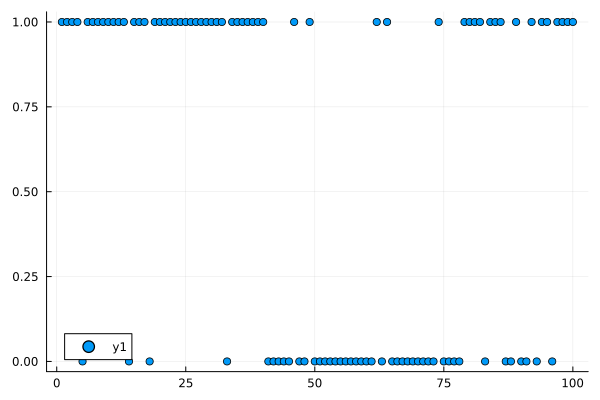

In [4]:
plot(inputs[1:100], seriestype=:scatter)

## 知覚モデル（HGF）の用意

以下の図(Mathys et al., 2014)は、入力が２値の場合の３階層HGFモデルです。

![](fig/fig2.jpeg)

簡単にまとめると、以下のようになる。

-  $x_{1}$ : 入力のカテゴリー（1か0か）。 $x_{2}$ をシグモイド変換して1か0にしている（ $x_{2}$ は高いほど１の可能性が高い）。
-  $x_{2}$ : カテゴリー１への傾向性（高いほどカテゴリー１の可能性が高い）。
-  $x_{3}$ : カテゴリー１への傾向性の対数変動性（ $x_{2}$ の変動性を調節する）。

パラメータの設定をしていきます。値は、[toreerdmann/HGF-workshop](https://github.com/toreerdmann/HGF-workshop)に従いました。

- evolution_rate: 状態の変化に関するステップサイズなので， $\omega$ に対応します。なお，最上位の場合は， $\vartheta$ を使うが，このパッケージではevolution_rateで統一される。
- initial_mean: 状態の分布の平均の初期値
- initial_precision: 状態の分布の精度（分散の逆数）の初期値
- value_coupling: 異なる階層をつなぐパラメータなので $\kappa$ に対応します。
- volatility_coupling: 異なる階層をつなぐパラメータなので $\kappa$ に対応する。

In [5]:
hgf_parameters = Dict(
    ("u", "category_means") => Real[0.0, 1.0],
    ("u", "input_precision") => Inf,
    ("x2", "evolution_rate") => -2.5,
    ("x2", "initial_mean") => 0,
    ("x2", "initial_precision") => 1,
    ("x3", "evolution_rate") => -6.0,
    ("x3", "initial_mean") => 1,
    ("x3", "initial_precision") => 1,
    ("x1", "x2", "value_coupling") => 1.0,
    ("x2", "x3", "volatility_coupling") => 1.0,
);

hgf = premade_hgf("binary_3level", hgf_parameters, verbose = false);

## 反応モデルの用意

Mathys et al.(2014)の43,44式（Figure 4）のunit square sigmoidを使います。これは、 $x_{1}$ の平均が1/2より大きければ１、小さければ０を返します（1/2なら0か1）。

In [6]:
agent_parameters = Dict("sigmoid_action_precision" => 5);
agent = premade_agent("hgf_unit_square_sigmoid_action", hgf, agent_parameters, verbose = false);

## エージェントを動かしてみる

知覚モデル、反応モデルの設定ができたので、入力をいれてエージェントを動かしてみます。

In [7]:
give_inputs!(agent, inputs);

## 軌道をプロットする

入力と $x_{1}$ の軌道をプロットします。

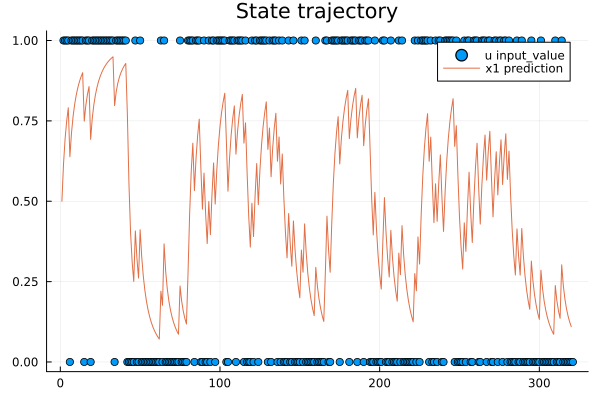

In [8]:
plot_trajectory(agent, ("u", "input_value"))
plot_trajectory!(agent, ("x1", "prediction"))

$x_{2}$ の軌道をプロットします。

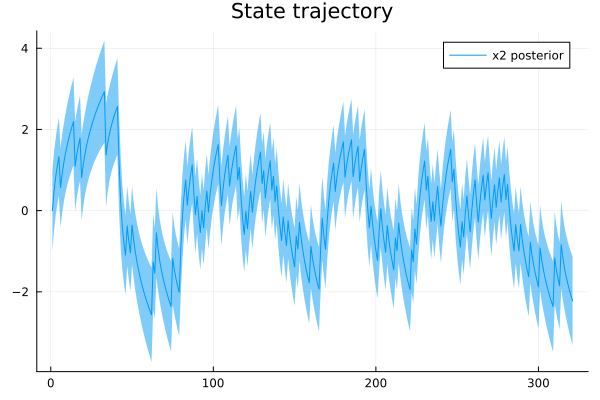

In [9]:
plot_trajectory(agent, ("x2", "posterior"))

$x_{3}$ の軌道をプロットします。

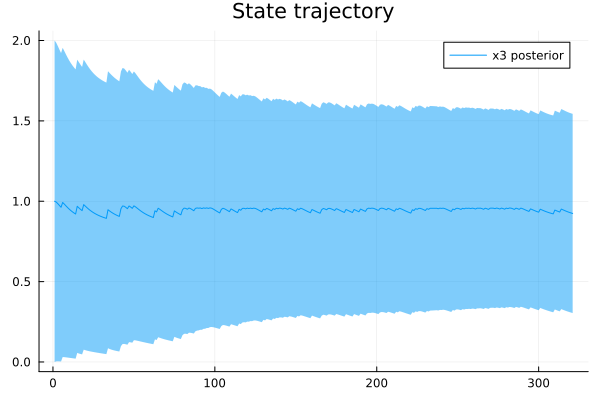

In [10]:
plot_trajectory(agent, ("x3", "posterior"))

## モデルフィッティング

モデルフィッティング（パラメータ推定）をする。

ここでは、 $\omega$ と $\zeta$ を推定するパラメータとして、その他をfixed_parametersとして設定する（ $\kappa$ は1に固定されている）。

In [11]:
fixed_parameters = Dict(
    ("u", "category_means") => Real[0.0, 1.0],
    ("u", "input_precision") => Inf,
    ("x2", "initial_mean") => 0,
    ("x2", "initial_precision") => 1,
    ("x3", "initial_mean") => 1,
    ("x3", "initial_precision") => 1,
    ("x1", "x2", "value_coupling") => 1.0,
    ("x2", "x3", "volatility_coupling") => 1.0,
);

続いて，推定するパラメータ（ $\omega$ と $\zeta$ ）の事前分布を以下のように設定します。

In [12]:
param_priors = Dict(("x2", "evolution_rate")   => truncated(Normal(-5.0, 2), -20, 0),
    ("x3", "evolution_rate")   => truncated(Normal(-5.0, 2), -20, 0),
    "sigmoid_action_precision" => truncated(Normal(1,5), 0, 20));

## 事前予測プロット

問題なく動作してそうです。


┌ Warning: the agent has parameters which are not specified in the fixed or sampled parameters. The agent's current parameter values are used instead
└ @ ActionModels ~/.julia/packages/ActionModels/PuyrO/src/plots/plot_predictive_simulation.jl:59
┌ Warning: 2 out of 100 sampled parameters were rejected
└ @ ActionModels ~/.julia/packages/ActionModels/PuyrO/src/plots/plot_predictive_simulation.jl:147


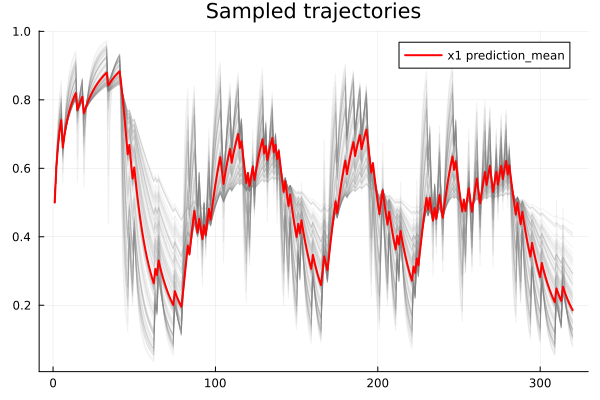

In [13]:
plot_predictive_simulation(
    param_priors,
    agent,
    inputs,
    ("x1", "prediction_mean"),
    n_simulations = 100,
)

### 反応データの読み込み

[toreerdmann/HGF-workshop](https://github.com/toreerdmann/HGF-workshop)で使われている反応を以下でも使います。

In [14]:
actions = Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0];

### fit_model()によるモデルフィッティング

In [15]:
fitted_model = fit_model(
    agent,
    param_priors,
    inputs,
    actions,
    fixed_parameters = fixed_parameters,
    verbose = true,
    n_chains = 4, 
)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:43


Chains MCMC chain (1000×15×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 185.35 seconds
Compute duration  = 183.34 seconds
parameters        = ("x3", "evolution_rate"), ("x2", "evolution_rate"), sigmoid_action_precision
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
                parameters      mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
                    Symbol   Float64   Float64    Float64   Float64     Float64   Float64       Float64 

  ("x3", "evolution_rate")   -5.5923    1.6895     0.0267    0.0253   4897.2446    0.9997       26.7113
  ("x2", "evolution_rate")   -2.2272    0.1568     0.0025    0.0026   3880.6191    0.9998       21.1662
  sigmoid_action_precision    4.5347    0.5785     0.0091    0

### MCMCチェーンの確認

plot(fit_model()の結果)でMCMCチェーンを確認する。

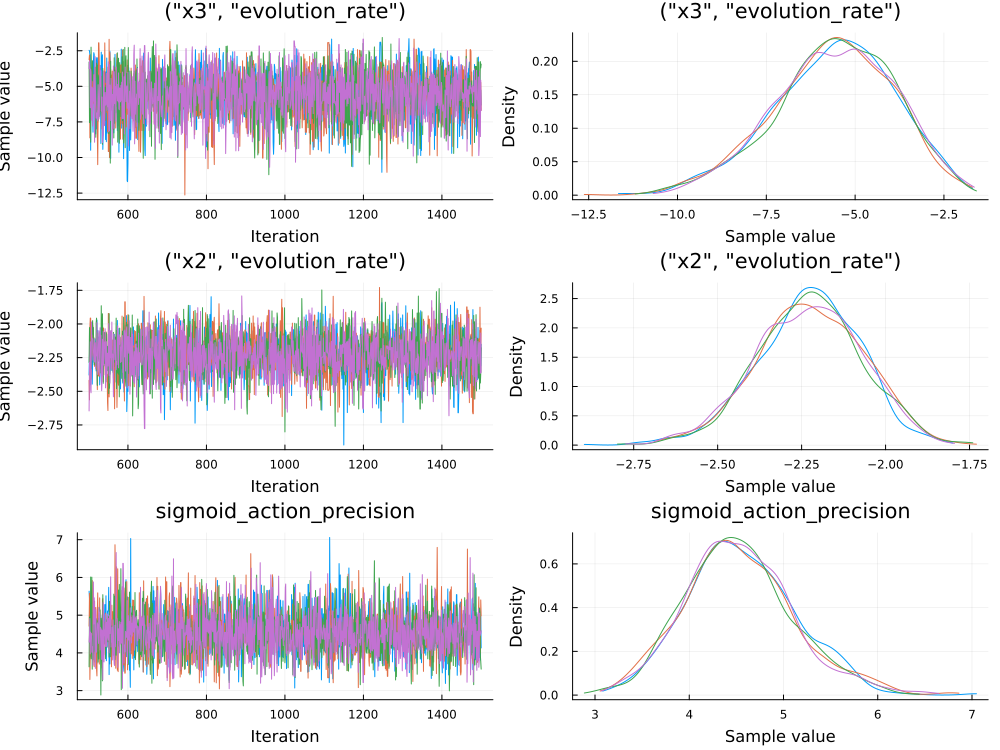

In [16]:
plot(fitted_model)

#### 事前分布と事後分布の重ね合わせプロット

plot_parameter_distribution()で、事前分布と事後分布の比較をする。

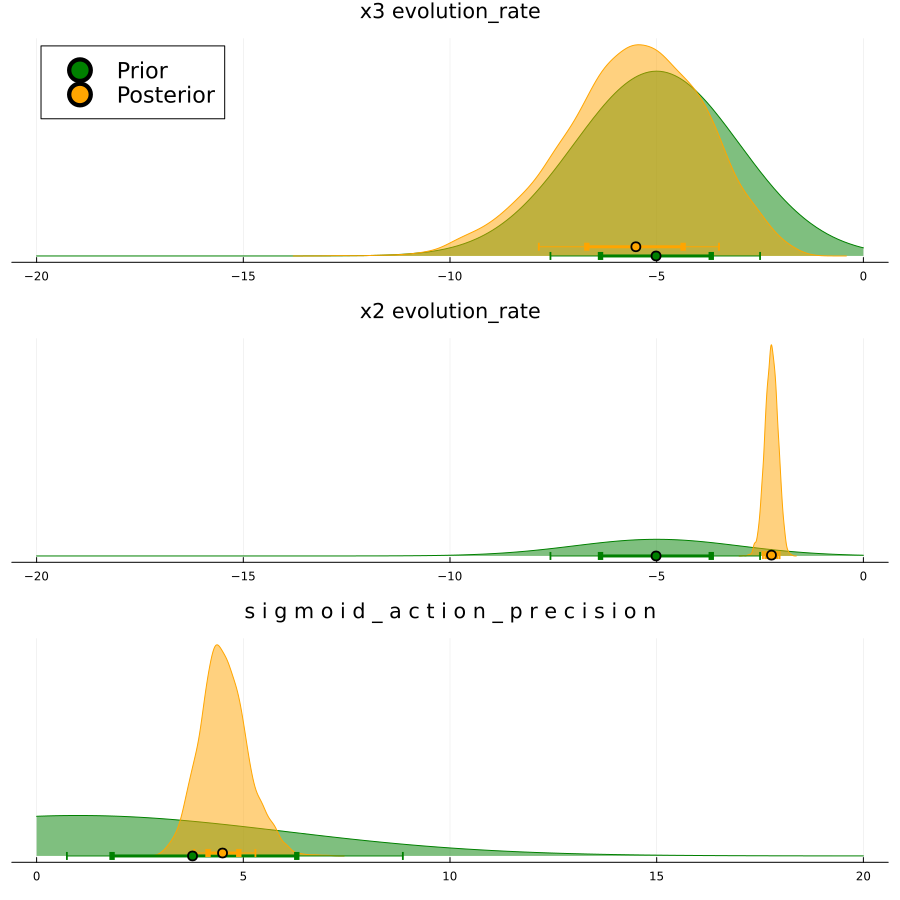

In [17]:
plot_parameter_distribution(fitted_model, param_priors)

## 事後予測シミュレーション

推定したパラメータをつかって事後予測シミュレーションをする。

┌ Warning: the agent has parameters which are not specified in the fixed or sampled parameters. The agent's current parameter values are used instead
└ @ ActionModels ~/.julia/packages/ActionModels/PuyrO/src/plots/plot_predictive_simulation.jl:59


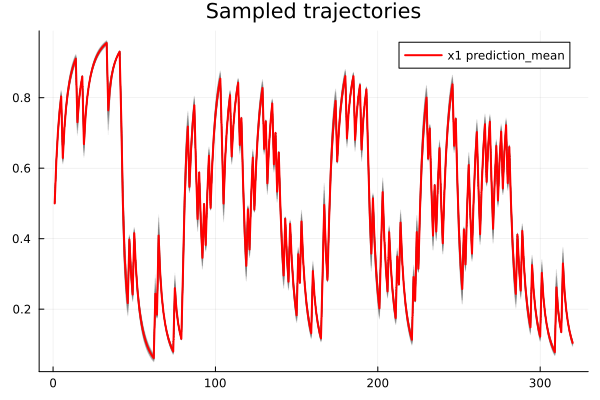

In [18]:
plot_predictive_simulation(
    fitted_model,
    agent,
    inputs,
    ("x1", "prediction_mean"),
    n_simulations = 100,
)

## モデル比較について

[02_continuous.ipynb](02_continuous.ipynb)と同様にWAICの計算が出来ないので，モデル比較は本チュートリアルに含めませんでした。WAICなどの計算が簡単になったら，試しに，２階層HGFなどを作ってみて比較すると良いかと思います。